# ----------------------------------
# Import modules
# ----------------------------------

In [1]:
import os
import requests                      # HTTP client for API calls
import pandas as pd                  # Tabular data handling
from datetime import datetime        # Datetime handling
from typing import Iterable, Optional, Dict, Union
import matplotlib.pyplot as plt
%pip install yfinance
import yfinance as yf
from src.exchange_rates import get_share_prices_2
from src.debug_print import debug_print
from src.plot_shares import plot_candles_with_volatility
from src.plot_shares_ROI import plot_candles_with_volatility_and_target as plt_vol_trg
from src.plot_shares_ROI2_1 import plot_candles_volatility_volume_roi as ROI
from src.fetch_lse_tickers import get_ftse100

Note: you may need to restart the kernel to use updated packages.


# ----------------------------------
# Import functions
# ----------------------------------

In [2]:

from src.debug_print import debug_print
from src.exchange_rates import get_exchange_rates, get_crypto_prices, get_fx_and_crypto, get_share_prices, convert_prices_to_base_currency, plot_fx_timeseries

# ----------------------------------
# Set up variables
# ----------------------------------

In [3]:
base_currency = "GBP"
target_currencies = ["USD", "GBP", "EUR", "JPY"]
cryptos = ["BTC", "ETH"]
shares = ['AAPL', 'RR.L', 'MSFT', 'NVDA', 'LDO.MI','4816.T']

start_date = datetime(2024, 6, 1)
purchase_date = datetime(2025, 6, 1)
end_date = pd.Timestamp.today().normalize()


# Get TOP 100 shares from FTSE

In [4]:
ftse100 = get_ftse100()
ftse100["Yahoo_Ticker"] = ftse100["Ticker"] + ".L"
shares_lse = ftse100["Yahoo_Ticker"].to_list()

[DEBUG] File: c:\Users\ingca\OneDrive\Documents\python\finance\src\utils\retry_decorator.py, Function: wrapper, Line: 38
None get_ftse100 succeeded


# --------------------------------
# SHARES' PRICES
# --------------------------------

In [13]:
df_shares2 = get_share_prices_2(
tickers=shares_lse,
start=start_date,
end=end_date,
base_currency = base_currency,
vol_window = 20,
)

# print(f"{debug_print()} get_share_prices_2:\n{df_shares2}")

actions_list   = df_shares2.columns.get_level_values("ACTION").unique().to_list()
print(f"{debug_print()} ACTIONS list:\n{[a.split(".L")[0] for a in actions_list]}")

currencies_list = df_shares2.columns.get_level_values("CURRENCY").unique()
metrics   = df_shares2.columns.get_level_values("METRIC").unique()

[DEBUG] File: c:\Users\ingca\OneDrive\Documents\python\finance\src\utils\retry_decorator.py, Function: wrapper, Line: 38
None get_share_prices_2 succeeded
[DEBUG] File: C:\Users\ingca\AppData\Local\Temp\ipykernel_4912\3586651156.py, Function: <module>, Line: 12
None ACTIONS list:
['III', 'ADM', 'AAF', 'ALW', 'AAL', 'ANTO', 'AHT', 'ABF', 'AZN', 'AUTO', 'AV', 'BAB', 'BA', 'BARC', 'BTRW', 'BEZ', 'BKG', 'BP', 'BATS', 'BLND', 'BT-A', 'BNZL', 'BRBY', 'CNA', 'CCEP', 'CCH', 'CPG', 'CTEC', 'CRDA', 'DCC', 'DGE', 'DPLM', 'EDV', 'ENT', 'EZJ', 'EXPN', 'FCIT', 'FRES', 'GAW', 'GLEN', 'GSK', 'HLN', 'HLMA', 'HIK', 'HSX', 'HWDN', 'HSBA', 'ICG', 'IHG', 'IMI', 'IMB', 'INF', 'IAG', 'ITRK', 'JD', 'KGF', 'LAND', 'LGEN', 'LLOY', 'LMP', 'LSEG', 'MNG', 'MKS', 'MRO', 'MTLN', 'MNDI', 'NG', 'NWG', 'NXT', 'PSON', 'PSH', 'PSN', 'PHNX', 'PCT', 'PRU', 'RKT', 'REL', 'RTO', 'RMV', 'RIO', 'RR', 'SGE', 'SBRY', 'SDR', 'SMT', 'SGRO', 'SVT', 'SHEL', 'SMIN', 'SN', 'SPX', 'SSE', 'STAN', 'STJ', 'TSCO', 'ULVR', 'UU', 'VOD', 'WEI

# ----------- PLOT SHARE - plot_candles_volatility_volume_roi ---------------


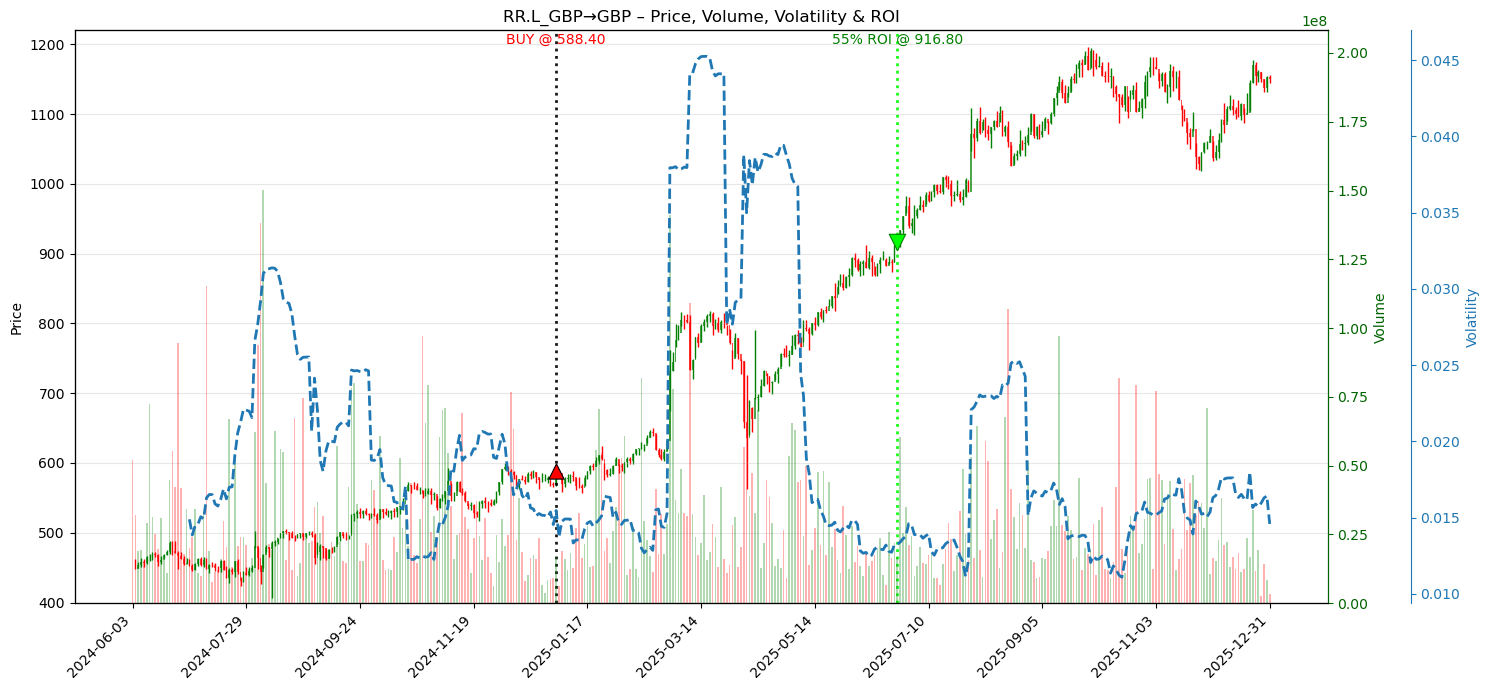

[DEBUG] File: c:\Users\ingca\OneDrive\Documents\python\finance\src\utils\retry_decorator.py, Function: wrapper, Line: 38
None plot_candles_volatility_volume_roi succeeded


In [10]:
ROI(
    df=df_shares2,
    actions=['RR.L_GBP→GBP'],
    start=df_shares2.index.min(),
    end=df_shares2.index.max(),
    purchase_date='2025-01-01',
    roi_target=0.55
)